# Goal

The idea of this notebook is to pre-process the image in order to make is easier to segment. Here are few things that we are going to do:

- Try to improve the contrast of the image by thresholding/playing with the intensity distribution (automatically)
- Try to "remove" background by segmenting algea that are in the middle of the image
- Removing pixels that are static ?

## Import the necessary packages

In [1]:
import skimage
import napari
from tifffile import imread,imwrite
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as sm
import seaborn as sns
import os
from scipy.optimize import curve_fit
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from matplotlib import animation
from IPython.display import HTML
import matplotlib as cm
from skimage.segmentation import morphological_chan_vese,checkerboard_level_set
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage import exposure
from skimage import img_as_float


### Load a "raw image"

In [2]:
path = Path('../data/new_movie_1.tif')
im = imread(path).astype('uint16')[1200:1330,...]
print(np.shape(im))

(130, 576, 576)


In [72]:
path = Path('../data/algae_replaced.tif')
im = imread(path).astype('uint8')
print(np.shape(im))

(346, 576, 576)


# 1 . Thresholding

### GIF making for all planes

In [ ]:
# Display the intensity profile of the image by making a gif of the histogram of all "planes"

data = im[0,...].flatten()
n, _ = np.histogram(data)

def prepare_animation(bar_container):
     
    def animate(frame_number):
        data = im[frame_number,...].flatten()
        n, _ = np.histogram(data)
         
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
         
        return bar_container.patches
     
    return animate


frame_number = 10 #np.shape(im)[0] # number of frames you want to plot np.shape(im)[0] if you want all of them

fig, ax = plt.subplots(figsize=(5, 5))

_, _, bar_container = ax.hist(data, lw=1,ec="red", fc="black", alpha=0.5)
plt.close()

ax.set_ylabel("Intensity")
ax.set_xlabel("Count")

fig.tight_layout()
ani = animation.FuncAnimation(fig, prepare_animation(bar_container), frame_number,repeat=True, blit=True)
HTML(ani.to_jshtml())


In [ ]:
f = r"../data/results/figures/contrast_enhancement/animation_intensity_time.gif" 
writergif = animation.PillowWriter(fps=5) 
ani.save(f, writer=writergif)

Determine the percentage of area occupied by the trichoplast and use it as a cut-off value

In [ ]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

l = []

for i in range(np.shape(im)[0]):
    
    data = im[i,...].flatten() 
    bins = np.linspace(data.min(),data.max(), 100)
    histo = np.histogram(data,bins = bins,density=True)[0]

    x = bins[:-1]
    y = histo

    expected=(120,50,0.015)

    params,cov=curve_fit(gauss, x, y, expected)
    sigma=list(np.sqrt(np.diag(cov)))
    df1 = pd.DataFrame([list(np.concatenate([params,sigma]).flat)],
                       columns=list(['mu','sigma','A','Err mu','Err sigma','Err A']))
    #print(df1)
    l.append(df1)
  

plt.plot(x,gauss(x,*params),color='red',lw=3,label='Gaussian fit')
plt.scatter(x,y,marker='.')
plt.legend()
plt.show()

df = pd.DataFrame(columns=list(['mu','sigma','A','Err mu','Err sigma','Err A']))
df = pd.concat(l)

df.index = [x for x in range(np.shape(im)[0])]
df.index.name="Plane"

print(df)

In [ ]:
# create a contrast corection function
'''
Workflow:
Loop over all planes
for all planes grab the corresponding fit and extract the mean (mu) and sigma
fix the value of the pixels at more than 2 sigma to 0
'''

cont_img = np.zeros_like(im)

for plane in range(np.shape(im)[0]):
    
    data= im[plane,...].copy()
    
    '''
    plt.imshow(data)
    plt.colorbar()
    plt.show()
    '''
    
    mu,sigm = df.mu[plane],df.sigma[plane]
            
    data[data<(mu-2*sigm)] = 0

    data[data>(mu+2*sigm)] = 0

    cont_img[plane,...] = data
    
    '''
    plt.imshow(data)
    plt.colorbar()
    plt.show()
    '''

print(np.shape(cont_img))

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(im[...].flatten(),color='blue')#,bins=bins)
plt.hist(cont_img[...].flatten(),alpha=0.7,color='orange')#,bins=bins) 
plt.legend(['Original image','Contrasted image'],loc='upper right')
plt.tight_layout()
plt.savefig('../data/results/figures/contrast_enhancement/contrast_cutoff_without_algae.png',dpi=300)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')
im = ax.imshow(cont_img[0,...], interpolation='bilinear')
fig.tight_layout()

def update(t):
    im.set_data(A_anim[t,...])
    return im,

nb_times_im = np.shape(cont_img)[0]

A_anim = cont_img[::cont_img.shape[-1]//nb_times_im ,...]
anim = animation.FuncAnimation(fig, update,
                               frames=nb_times_im, interval=50, 
                               blit=True)
HTML(anim.to_jshtml())

In [ ]:
f = r"../data/results/figures/contrast_enhancement/animation_contrast_enhanced.gif" 
writergif = animation.PillowWriter(fps=5) 
anim.save(f, writer=writergif)

In [ ]:
imwrite('../data/algae_removed_contrasted.tif',cont_img)

In [ ]:
i = 30
plt.imshow(im[i,...])

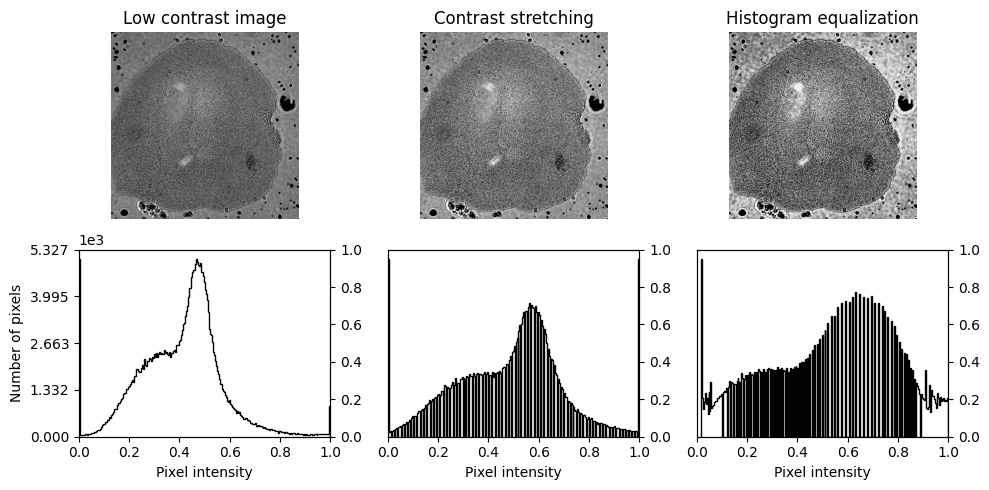

In [19]:
img = im[30,...].copy()
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram
    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    return ax_img, ax_hist

# Display results
fig = plt.figure(figsize=(10, 5))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = fig.add_subplot(2, 3, 1)
for i in range(1, 3):
    axes[0, i] = fig.add_subplot(2, 3, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 3):
    axes[1, i] = fig.add_subplot(2, 3, 4+i)

ax_img, ax_hist= plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist= plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')


# prevent overlap of y-axis labels
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/contrast_stretching_equalization.png',dpi=300)
plt.show()

## Enhance the contrast for all planes

In [73]:
stretch = np.zeros_like(im)
eq = []

for i in range(np.shape(im)[0]):
    
    # Equalization
    img = im[i,...].copy()
    
    eq.append(exposure.equalize_hist(img))
    
    # Rescaling
    img = im[i,...].copy()
    p2, p98 = np.percentile(img, (2, 98))
    stretch[i,...] = exposure.rescale_intensity(img, in_range=(p2, p98))
    

In [74]:
imwrite('../data/tricho8_stretched_filled.tif',stretch)
imwrite('../data/tricho8_equalized_filled.tif',eq)


# Segmenting the algae 

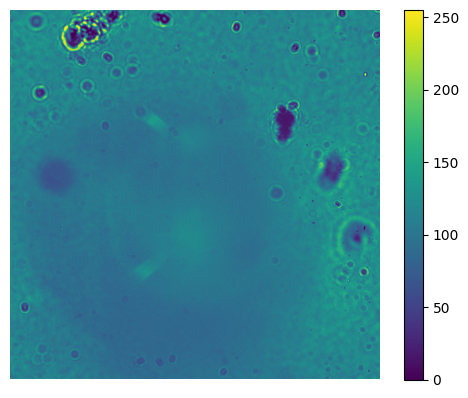

In [35]:
#projecting the image in order to average all plane and get the position of the static elements

im_p = np.mean(im,axis=0)
plt.axis('off')
plt.imshow(im_p,origin='lower')
plt.colorbar()
plt.show()


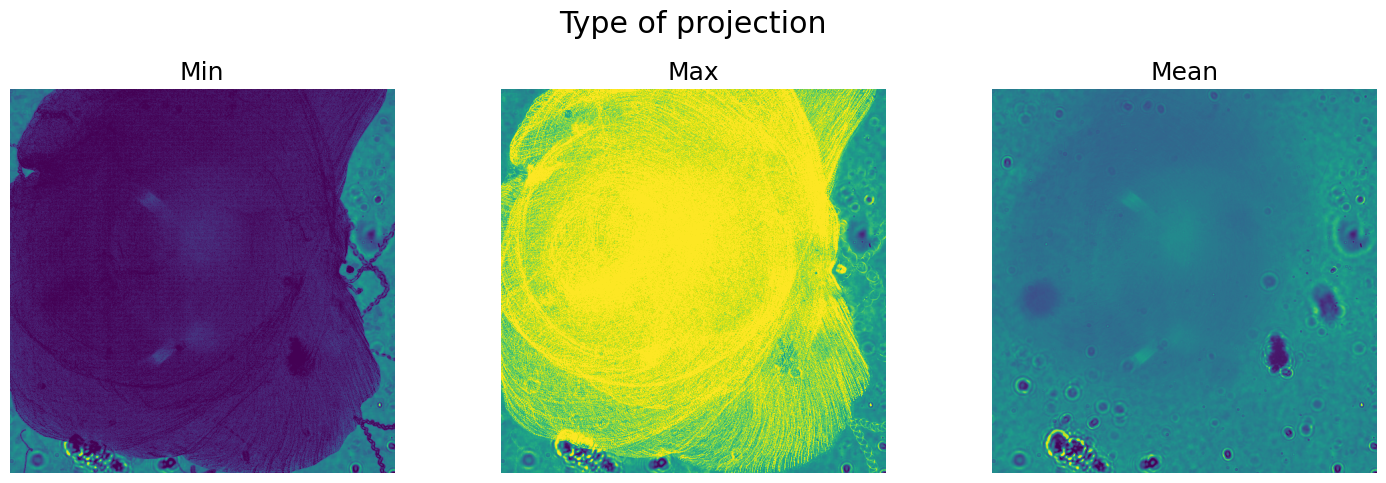

In [36]:
sns.set_context("talk")
# Plot the difference between mean,min and max projection

fig,ax = plt.subplots(1,3,figsize=(15,5))
l = ['Min','Max','Mean']

op = [np.min(im,axis=0),np.max(im,axis=0),np.mean(im,axis=0)]
for i,ax,l in zip(op,ax,l):
    ax.imshow(i)
    ax.set_title(l)
    ax.axis('off')
    
fig.suptitle('Type of projection')
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/type_of_projection.png',dpi=300)
plt.show()

We can stick to the mean projection to perform the segmentation

### Manual segmentation

In [ ]:
# inverse the color such that algea are high pixel intensity

fix,ax = plt.subplots(1,2)
i = im_p.copy()

i[i > 80] = 255.

i[i<255] = 100000

i[i != 100000] = 0.

ax[0].imshow(im_p)
ax[1].imshow(i)

for ax in ax:
    ax.axis('off')
    
plt.imshow(i)
plt.colorbar()

the segmentation might not be required as when inverting the image we are left with only the algaes

### Automatic segmentation

In [44]:
# segment 
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=1)
    #image = im_p
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    #ms_filled = im_ms
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))

    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    #binary_mask = np.where(labels == vol_list.index(min(vol_list))+1, 1, 0)

    
    #remove the largest component from the image
    
    m = ms_filled - binary_mask
    
    #m = binary_mask
    
    return m

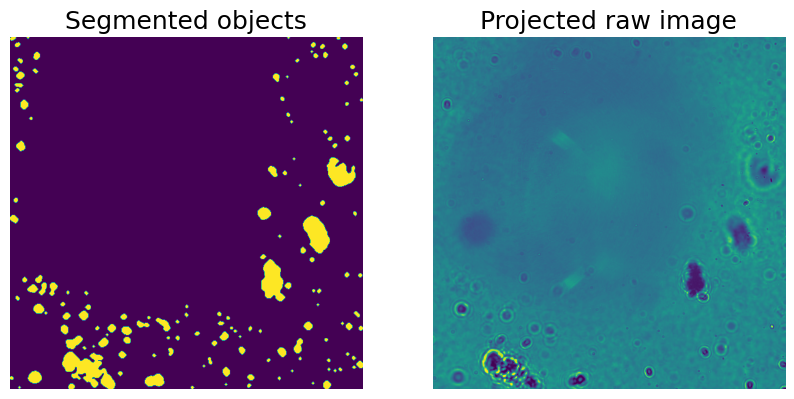

In [45]:
m = segm_alg(im_p)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(m)
ax[1].imshow(im_p)

l = ['Segmented objects','Projected raw image']

for j,ax in enumerate(ax):
    ax.axis('off')
    ax.set_title(l[j])
plt.show()

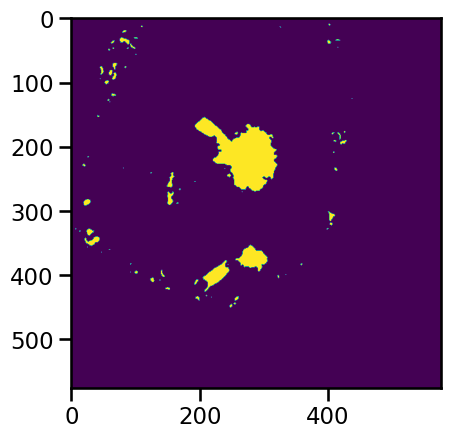

In [39]:
from skimage.segmentation import clear_border

def get_holes_mask(mask):
    mask = np.array(mask)

    inverted_mask= mask.copy() #copy the original mask
    # inverse the mask. The idea is to extract only the small object (= the wound) in the middle of the image, and to remove everything around.
    inverted_mask[mask==0]=1
    inverted_mask[mask==1]=0
    # remove objects touching the borders.
    mask_cleared = clear_border(inverted_mask)
    return mask_cleared

plt.imshow(get_holes_mask(m))

alg = get_holes_mask(m)

In [46]:
lab = label(alg)
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

df = pd.DataFrame(props)
df#.head()

,centroid-0,centroid-1,area,slice,intensity_mean
0,9.833333,401.833333,6,"(slice(9, 12, None), slice(401, 404, None))",109.805395
1,12.600000,109.800000,5,"(slice(12, 14, None), slice(109, 112, None))",111.619075
2,13.500000,325.500000,2,"(slice(13, 15, None), slice(325, 327, None))",121.197977
3,20.312500,82.500000,16,"(slice(19, 23, None), slice(80, 86, None))",110.682623
4,34.725275,82.956044,91,"(slice(30, 41, None), slice(76, 91, None))",111.061107
...,...,...,...,...,...
74,435.520000,196.840000,25,"(slice(433, 440, None), slice(194, 200, None))",110.303121
75,436.000000,257.500000,28,"(slice(433, 440, None), slice(255, 261, None))",108.870252
76,434.000000,218.000000,1,"(slice(434, 435, None), slice(218, 219, None))",113.118497
77,444.000000,254.500000,8,"(slice(443, 446, None), slice(253, 257, None))",110.730130


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

ima = im[50:129,...]#,513:533,537:564].copy()

imag = ax.imshow(ima[0,...], interpolation='bilinear')
fig.tight_layout()

def update(t):
    imag.set_data(A_anim[t,...])
    ax.set_title(t)
    return imag,

nb_times_im = np.shape(ima)[0]

A_anim = ima[::ima.shape[0]//nb_times_im,...]

anim = animation.FuncAnimation(fig, update,
                               frames=nb_times_im, interval=50, 
                               blit=True)
HTML(anim.to_jshtml())

AxesSubplot(0.31875,0.11;0.0341912x0.77)


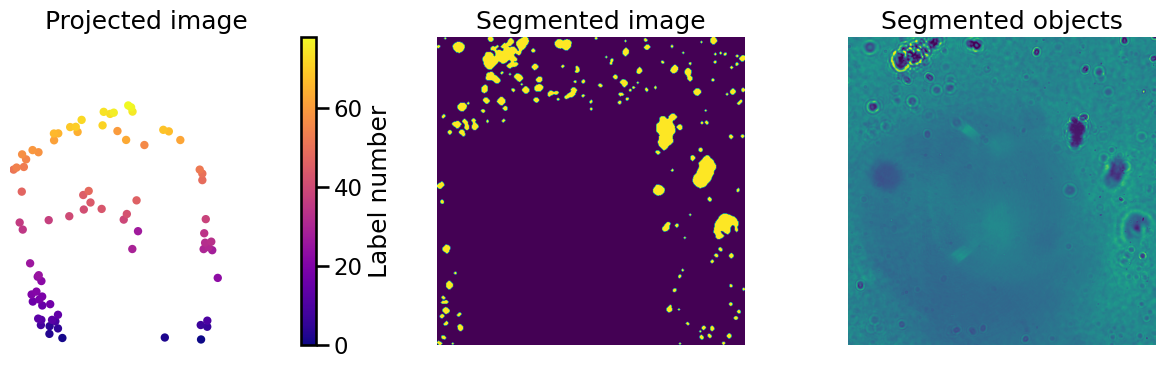

In [48]:
sns.set_context("talk")

fix,ax = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)

c = [x for x in df.index.values]

s = ax[0].scatter(df['centroid-1'],df['centroid-0'],marker='.',c=c,cmap='plasma')
ax[1].imshow(m,origin='lower')
ax[2].imshow(im_p,origin='lower')

title = ['Projected image','Segmented image','Segmented objects']

fig.colorbar(s, ax=ax[0])

for ax,t in zip(ax,title):
    ax.axis('off')
    ax.set_title(t)
    
f = plt.gcf()

cax = f.get_axes()[-1]
print(cax)
cax.set_ylabel('Label number')
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_detection_automatic.png',dpi=300)
plt.show()

## Test to remove the algae

In [50]:
mask = imread('../data/results/chan_vese/placozoan-movie_masked_chanvese.tif')

random color map:

viridis = cm.colormaps['viridis'].resampled(len(position.index))


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

im_test = im[3,...].copy() # image to crop

ax[0].imshow(im_test)

for i in df.index.values:
    im_test[df.iloc[i]['slice']] = 0


ax[1].imshow(im_test)

l = ['Raw image','Algae removed']
for k,ax in enumerate(ax):
    ax.axis('off')
    ax.set_title(l[k])
   

fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic.png',dpi=300)
plt.show()


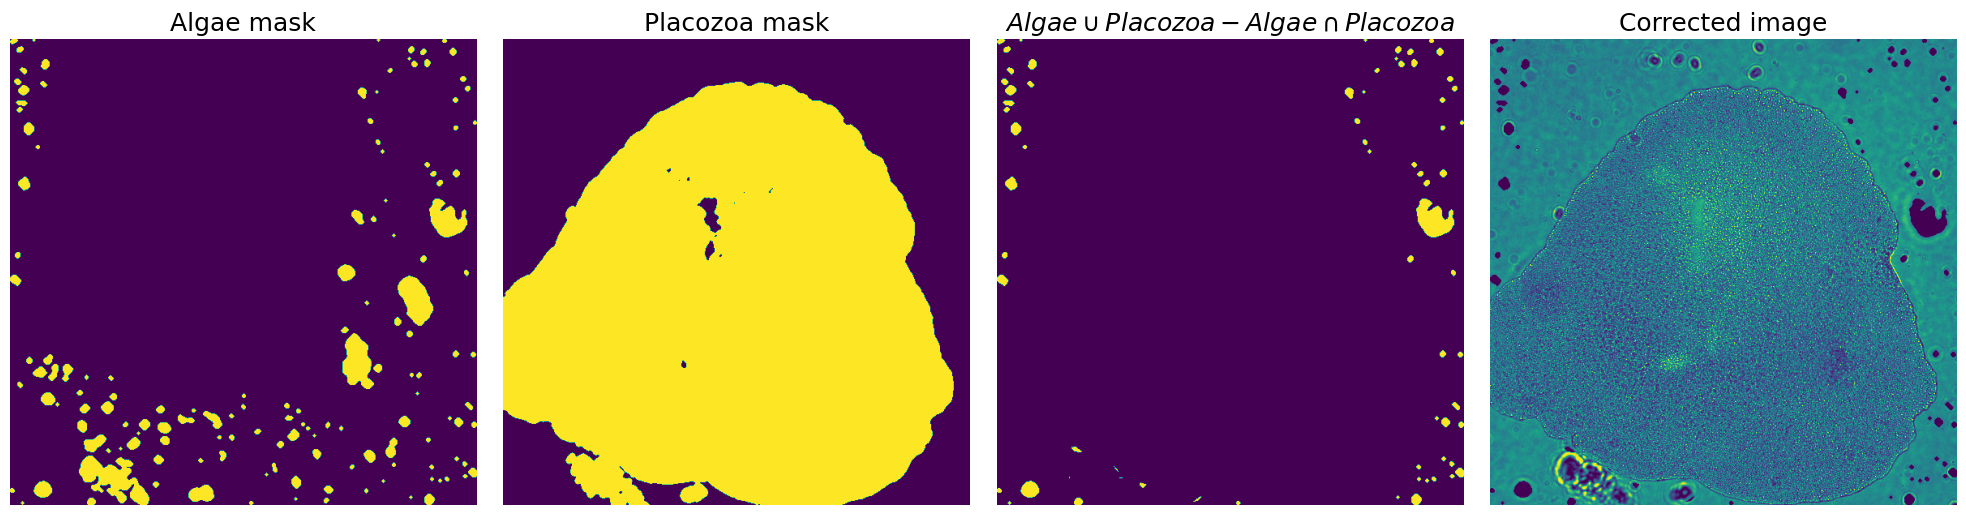

In [51]:
sns.set_context("talk")
fig,ax = plt.subplots(1,4, figsize=(20,7))

#create the mask by subtracting the algae and the environment

ma = m.copy()

mask_img = ma * (mask[3,...] == 0.)

#correct the image based on the substraction

im_test = im[3,...].copy()

newImage = im_test * (mask_img==0)

# plot 

ax[0].imshow(ma)
ax[1].imshow(mask[3,...])
ax[2].imshow(mask_img)
ax[3].imshow(newImage)

lab = ['Algae mask','Placozoa mask','$Algae\cup Placozoa - Algae\cap Placozoa$','Corrected image']
for k,ax in enumerate(ax):
    ax.set_title(lab[k])
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_proof_of_concept.png',dpi=300)

(array([  5141.,  24971.,  48616.,  56156., 111627.,  57498.,  15849.,
          6063.,   2959.,   2896.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

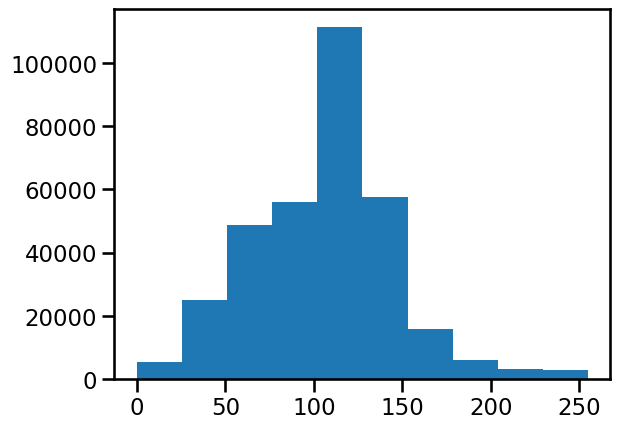

In [58]:
plt.hist(im[3,...].flatten())

In [69]:
def correct(mask_alg,mask_plac,raw_img):
    
    #initialize the corrected raw image
    
    new_image = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment

        mask_img = mask_alg * (mask_plac[plane,...] == 0.)

        #correct the image based on the substraction

        new_image[plane,...] = raw_img[plane,...] * (mask_img == 0.)
        
        new_image[plane,...][new_image[plane,...] == 0] = 50 # change the value of the algae by 50 (arbitrary)
        
    #'''
        
    return new_image

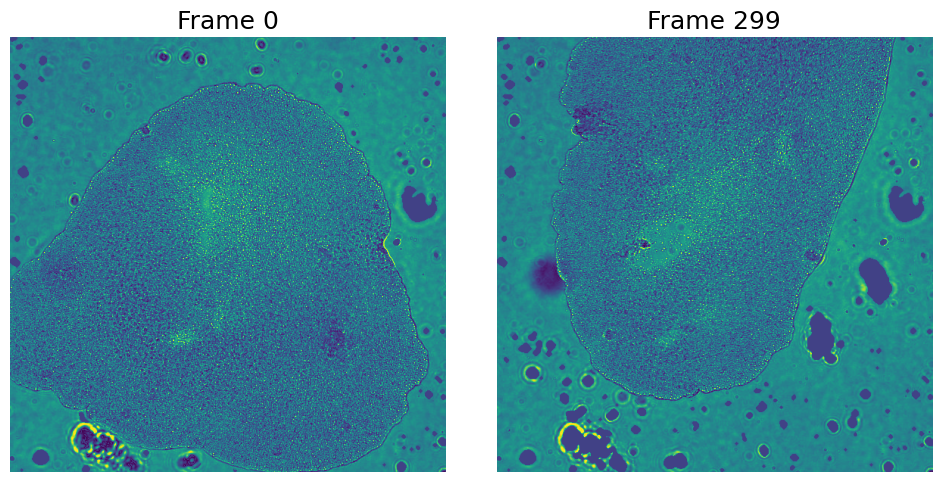

In [70]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

contr = correct(ma,mask,im)

for i,ax in zip([ 1 , 300 ],ax):
    ax.imshow(contr[i,...])
    ax.set_title(f'Frame {i-1}')
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_corrected_image.png',dpi=300)

In [71]:
imwrite('../data/algae_replaced.tif',contr)

In [ ]:
plt.hist(newImage.flatten())
plt.show()

In [ ]:
def segm_rem(im_p,n_sigm):
    
    '''
    Function to segment and see the impact of replacing algae by different background values
    Worflow:
    compute the sd of the pixel intensity distribution
    segment with the adition of n sigma value to the algae
    
    '''
    sigm = np.std(im_p)
    mean = np.mean(im_p)
    
    correction = (mean-(n_sigm*sigm))
    
    if correction < 0:
        correction = 0

    im_p[im_p == 0] = correction
  
    #gaussian blurr
    #image = gaussian(im_p,sigma=1)
    
    #segment using also a smoothing
    im_ms = morphological_chan_vese(im_p,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    #ms_filled = ndimage.binary_dilation(ms_filled)
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))

    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    
    #'''
    return [binary_mask,im_p]

In [ ]:
path = Path('../data/algae_removed.tif')
im = imread(path)
im = im[40,...]
print(np.shape(im))

plt.imshow(im)

In [ ]:
masked = imread('../data/results/chan_vese/without_algae_masked.tif')

plt.imshow(masked[40,...])

In [ ]:
sns.set_context('notebook')

fig, ax = plt.subplots(1,4,figsize=(10,5))

ax = ax.flatten()
l = [2,2,4,4]
counter = [1,0,1,0]

la = ['Raw image filled', 'Corresponding segmentation','Raw image','Corresponding segmentation']

for n,i in enumerate(ax):
    ima = im.copy()
    print(l[n])
    i.imshow(segm_rem(ima,l[n])[counter[n]])
    i.axis('off')
    i.set_title(la[n])
    
fig.tight_layout()
plt.savefig('../data/results/figures/contrast_enhancement/filling_algaes.png',dpi=300)